# Multi Resolution Simulation

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha)

GPUOcean code from: 97a3e393126f23791f2f0591ef1c07e6ea482509


### Classes and modules

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [3]:
from gpuocean.utils import Common, NetCDFInitialization
from gpuocean.SWEsimulators import CDKLM16, CDKLM16pair

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [4]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [5]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    }

In [6]:
pert_args = {
    "small_scale_perturbation" : True,
    "small_scale_perturbation_interpolation_factor" : 21,
    "small_scale_perturbation_amplitude" : 0.00025,    
    "small_scale_perturbation_dx" : 400,
    "small_scale_perturbation_dy" : 400,
}

In [7]:
T = 12
subT = 300

In [8]:
loc = [[50,50],[250,450]]
scale = 1.5 # NOTE: We use constant, Could also be lists of length L

## Sample size

In [9]:
N = 2

## Levels

In [10]:
L = 1 #root=0

In [11]:
gpu_ctxs = []
for i in range(L+1):
    gpu_ctxs.append(Common.CUDAContext())

slave_gpu_ctxs = []
for i in range(L+1):
    slave_gpu_ctxs.append(Common.CUDAContext())

### Utils 

In [12]:
# Set up new simulations
sim = CDKLM16.CDKLM16(gpu_ctxs[0], **sim_args, **data_args)
slave = CDKLM16.CDKLM16(slave_gpu_ctxs[0], **sim_args, **data_args)   

# Initialise L levels
child = sim
slave_child = slave
for l in range(1,L+1):
    child.give_birth(gpu_ctxs[l], loc, scale)
    child = child.children[0]
    if l < L:
        slave_child.give_birth(slave_gpu_ctxs[l], loc, scale)
        slave_child = slave_child.children[0]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


In [13]:
def MultiResNorm(sim, slave=None):

    def squared_level_norm(level_sim, level_slave):
        eta = copy.deepcopy(level_sim.download(interior_domain_only=True)[0])
        hu  = copy.deepcopy(level_sim.download(interior_domain_only=True)[1])
        hv  = copy.deepcopy(level_sim.download(interior_domain_only=True)[2])
        if level_slave is not None:
            slave_eta = copy.deepcopy(level_sim.download(interior_domain_only=True)[0])
            slave_hu  = copy.deepcopy(level_sim.download(interior_domain_only=True)[1])
            slave_hv  = copy.deepcopy(level_sim.download(interior_domain_only=True)[2])
        for child in level_sim.children:
            child_loc = child.level_local_area  
            eta[child_loc[0][0]:child_loc[1][0], child_loc[0][1]:child_loc[1][1]] = 0.0
            hu[child_loc[0][0]:child_loc[1][0], child_loc[0][1]:child_loc[1][1]] = 0.0
            hv[child_loc[0][0]:child_loc[1][0], child_loc[0][1]:child_loc[1][1]] = 0.0
            if level_slave is not None:
                slave_eta[child_loc[0][0]:child_loc[1][0], child_loc[0][1]:child_loc[1][1]] = 0.0
                slave_hu[child_loc[0][0]:child_loc[1][0], child_loc[0][1]:child_loc[1][1]] = 0.0
                slave_hv[child_loc[0][0]:child_loc[1][0], child_loc[0][1]:child_loc[1][1]] = 0.0
        if level_slave is not None:
            eta = eta - slave_eta
            hu  = hu  - slave_hu
            hv  = hv  - slave_hv
        return np.array([np.linalg.norm(eta.filled(0.0))**2, np.linalg.norm(hu.filled(0.0))**2, np.linalg.norm(hv.filled(0.0))**2]) * (level_sim.dx*level_sim.dy)

    def squared_all_level_norm(level_sim, level_slave, squared_level_norms=np.zeros(3)):
        level_adds = np.zeros(3)
        for c in range(len(level_sim.children)):
            slave_child = None
            if level_slave is not None:
                forget_child = False
                if len(level_slave.children) == 0:
                    # NOTE: We assume that the slave abruptly stops at a certain level,
                    # but shares the others levels with the master sim
                    level_slave.give_birth(slave_gpu_ctxs[-1], level_sim.children[c].level_local_area, level_sim.children[c].level_rescale_factor)
                    forget_child = True
                    slave_child = level_slave.children[0]
                else: 
                    slave_child = level_slave.children[c] 
            level_adds += squared_all_level_norm(level_sim.children[c], slave_child, squared_level_norms)
            if level_slave is not None:
                if forget_child:
                    level_slave.children = []
        level_adds += squared_level_norm(level_sim, level_slave)
        return squared_level_norms + level_adds

    return np.sqrt(squared_all_level_norm(sim, slave))


In [14]:
MultiResNorm(sim)

array([  112593.54623354, 12523373.7494577 ,  8344415.35580024])

In [15]:
MultiResNorm(sim, slave)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


array([0., 0., 0.])

# Mean Estimator $\mathbb{E}\lVert u^l - u^{l-1} \rVert_{D^l}$

In [16]:
level_fields = [np.ma.zeros((3,sim.ny,sim.nx))]

level_sim = sim
while len(level_sim.children)>0:
    level_sim = level_sim.children[0]
    level_fields.append(np.ma.zeros((3,level_sim.ny,level_sim.nx)))

In [17]:
level_E_states = copy.deepcopy(level_fields)
level_E_diffs  = copy.deepcopy(level_fields)

In [18]:
E_norm_diff = np.zeros(3)

In [19]:
for n in range(N):
    # Set up new simulations
    sim = CDKLM16.CDKLM16(gpu_ctxs[0], **sim_args, **data_args)
    slave = CDKLM16.CDKLM16(slave_gpu_ctxs[0], **sim_args, **data_args)   

    # Initialise L levels
    child = sim
    slave_child = slave
    for l in range(1,L+1):
        child.give_birth(gpu_ctxs[l], loc, scale)
        child = child.children[0]
        if l < L:
            slave_child.give_birth(slave_gpu_ctxs[l], loc, scale)
            slave_child = slave_child.children[0]

    # Pair sims and step ahead in time
    sim_pair = CDKLM16pair.CDKLM16pair(sim, slave, **pert_args)
    for t_steps in range(T): 
        sim_pair.step(subT, apply_stochastic_term=True) # model error after every step()-call

    # estimator for QOI
    E_norm_diff += MultiResNorm(sim_pair.sim, sim_pair.slave_sim)

    # Save average state
    l = 0
    level_sim = sim_pair.sim

    level_eta, level_hu, level_hv = level_sim.download(interior_domain_only=True)
    level_E_states[l][0] += 1/N*level_eta
    level_E_states[l][1] += 1/N*level_hu
    level_E_states[l][2] += 1/N*level_hv 

    while len(level_sim.children)>0:
        l += 1
        level_sim = level_sim.children[0]
        
        level_eta, level_hu, level_hv = level_sim.download(interior_domain_only=True)
        level_E_states[l][0] += 1/N*level_eta
        level_E_states[l][1] += 1/N*level_hu
        level_E_states[l][2] += 1/N*level_hv 

    # Save difference state
    l = 0
    level_sim = sim_pair.sim
    level_slave_sim = sim_pair.slave_sim

    level_eta, level_hu, level_hv = level_sim.download(interior_domain_only=True)
    level_slave_eta, level_slave_hu, level_slave_hv = level_slave_sim.download(interior_domain_only=True)
    level_E_diffs[l][0] += 1/N*(level_eta-level_slave_eta)
    level_E_diffs[l][1] += 1/N*(level_hu-level_slave_hu)
    level_E_diffs[l][2] += 1/N*(level_hv-level_slave_hv) 

    while len(level_sim.children)>0:
        l += 1
        level_sim = level_sim.children[0]

        forget_child = False
        if len(level_slave_sim.children) == 0:
            # NOTE: We assume that the slave abruptly stops at a certain level,
            # but shares the others levels with the master sim
            level_slave_sim.give_birth(slave_gpu_ctxs[-1], level_sim.level_local_area, level_sim.level_rescale_factor)
            forget_child = True
            level_slave_sim = level_slave_sim.children[0]
        else: 
            level_slave_sim = level_slave_sim.children[0] 

        level_eta, level_hu, level_hv = level_sim.download(interior_domain_only=True)
        level_slave_eta, level_slave_hu, level_slave_hv = level_slave_sim.download(interior_domain_only=True)
        level_E_diffs[l][0] += 1/N*(level_eta-level_slave_eta)
        level_E_diffs[l][1] += 1/N*(level_hu-level_slave_hu)
        level_E_diffs[l][2] += 1/N*(level_hv-level_slave_hv) 
        
        if forget_child:
            level_slave_sim.children = []

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.
The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.
The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [20]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# Also see https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html 

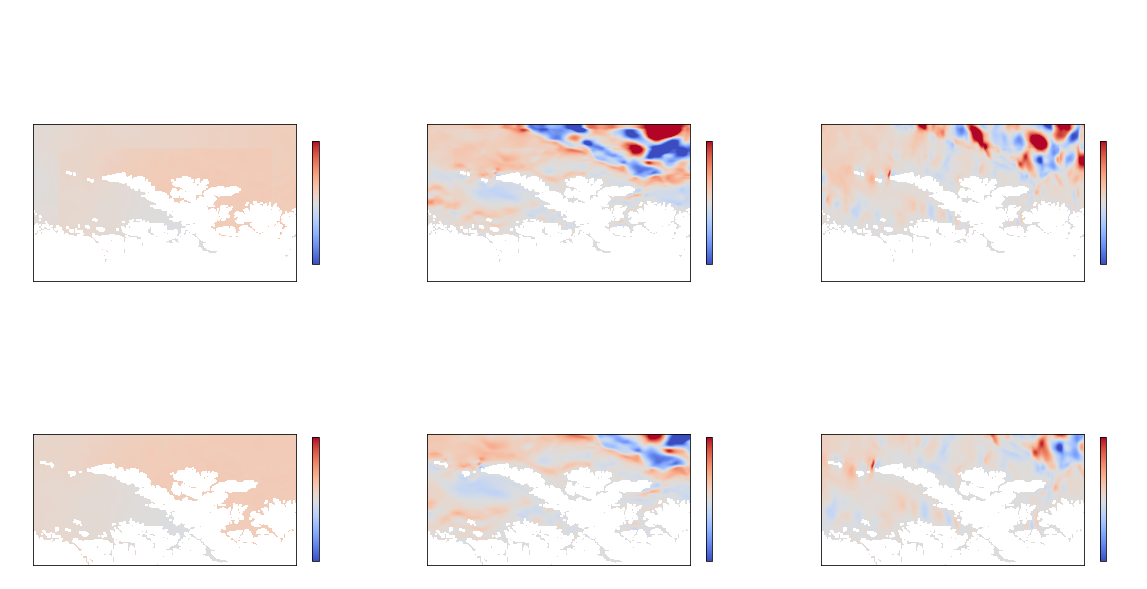

In [35]:
fig, axs = plt.subplots(L+1,3, figsize=(20,10))
fig.suptitle("Mean states")

for l in range(L+1):
    im = axs[l,0].imshow(level_E_states[l][0], vmin=-2.5, vmax=2.5, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l,0], shrink=0.5)

    im = axs[l,1].imshow(level_E_states[l][1], vmin=-125, vmax=125, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l,1], shrink=0.5)

    im = axs[l,2].imshow(level_E_states[l][2], vmin=-125, vmax=125, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l,2], shrink=0.5)


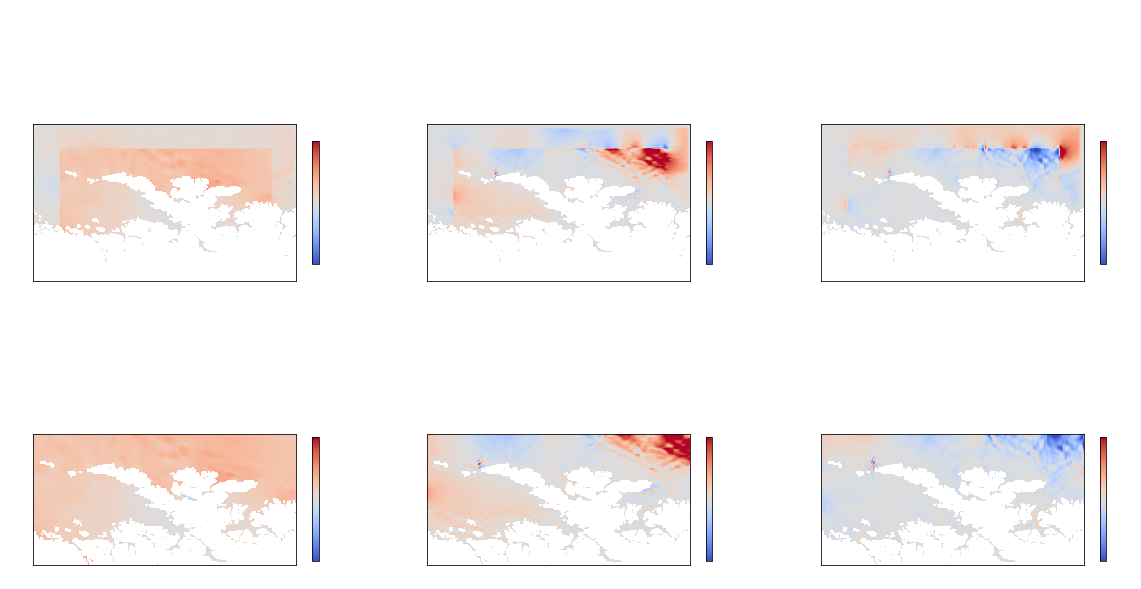

In [39]:
fig, axs = plt.subplots(L+1,3, figsize=(20,10))
fig.suptitle("Difference states")

for l in range(L+1):
    im = axs[l,0].imshow(level_E_diffs[l][0], vmin=-0.5, vmax=0.5, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l,0], shrink=0.5)

    im = axs[l,1].imshow(level_E_diffs[l][1], vmin=-25, vmax=25, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l,1], shrink=0.5)

    im = axs[l,2].imshow(level_E_diffs[l][2], vmin=-25, vmax=25, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l,2], shrink=0.5)

# Variance Estimator

In [ ]:
for n in range(N):
    # Set up new simulations
    sim = CDKLM16.CDKLM16(gpu_ctxs[0], **sim_args, **data_args)
    slave = CDKLM16.CDKLM16(slave_gpu_ctxs[0], **sim_args, **data_args)   

    # Initialise L levels
    child = sim
    slave_child = slave
    for l in range(1,L+1):
        child.give_birth(gpu_ctxs[l], loc, scale)
        child = child.children[0]
        if l < L:
            slave_child.give_birth(slave_gpu_ctxs[l], loc, scale)
            slave_child = slave_child.children[0]

    # pair slave and step ahead in time
    sim_pair = CDKLM16pair.CDKLM16pair(sim, slave, **pert_args)
    for five in range(T): 
        sim_pair.step(subT, apply_stochastic_term=True) # model error after every step()-call
    
    # Finest levels
    level_sim = sim_pair.sim
    slave_level_sim = sim_pair.slave_sim
    for l in range(1,L+1):
        level_sim = level_sim.children[0]
        if l < L:
            slave_level_sim = slave_level_sim.children[0]
    
    eta, hu, hv = level_sim.download()
    slave_level_sim.give_birth(slave_gpu_ctxs[-1], loc, scale)
    slave_eta, slave_hu, slave_hv = slave_level_sim.children[0].download()
    slave_level_sim.kill_child()

    if n == 0:
        VarDiff = np.ma.array([((eta - slave_eta) - Ediff[0])**2/(N-1), ((hu - slave_hu) - Ediff[1])**2/(N-1), ((hv - slave_hv) - Ediff[2])**2/(N-1)])
    else:
        VarDiff += np.ma.array([((eta - slave_eta) - Ediff[0])**2/(N-1), ((hu - slave_hu) - Ediff[1])**2/(N-1), ((hv - slave_hv) - Ediff[2])**2/(N-1)])

    if n==0:
        Var = np.ma.array([(eta - E[0])**2/(N-1), (hu - E[1])**2/(N-1), (hv - E[2])**2/(N-1)])
    else:
        Var += np.ma.array([(eta - E[0])**2/(N-1), (hu - E[1])**2/(N-1), (hv - E[2])**2/(N-1)])

    # TEMP 
    if n == 0:
        level_sims = np.ma.zeros((N,3,eta.shape[0], eta.shape[1]))
        level_sims[n] = np.ma.array([eta, hu, hv])
        slave_level_sims = np.ma.zeros((N,3,eta.shape[0], eta.shape[1]))
        slave_level_sims[n] = np.ma.array([slave_eta, slave_hu, slave_hv])
    else:
        level_sims[n] = np.ma.array([eta, hu, hv])
        slave_level_sims[n] = np.ma.array([slave_eta, slave_hu, slave_hv])

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

im = axs[0,0].imshow(VarDiff[0], vmax=0.01)
plt.colorbar(im, ax=axs[0,0], shrink=0.5)

im = axs[0,1].imshow(VarDiff[1], vmax=100)
plt.colorbar(im, ax=axs[0,1], shrink=0.5)

im = axs[0,2].imshow(VarDiff[2], vmax=100)
plt.colorbar(im, ax=axs[0,2], shrink=0.5)


im = axs[1,0].imshow(Var[0], vmax=0.01)
plt.colorbar(im, ax=axs[1,0], shrink=0.5)

im = axs[1,1].imshow(Var[1], vmax=100)
plt.colorbar(im, ax=axs[1,1], shrink=0.5)

im = axs[1,2].imshow(Var[2], vmax=100)
plt.colorbar(im, ax=axs[1,2], shrink=0.5)

In [ ]:
[np.linalg.norm(field)/np.prod(field.shape) for field in Var]

In [ ]:
[np.linalg.norm(field)/np.prod(field.shape) for field in VarDiff]

In [ ]:
# https://en.wikipedia.org/wiki/Kahan_summation_algorithm
sum = 0.0 
sum_corr = 0.0

for n in range(N):
    summand = n - sum_corr
    tmp_sum = sum + summand
    sum_corr = (tmp_sum - sum) - summand
    sum = tmp_sum
